# Data Preprocessing and Pyspark Session

####  Initialize SparkSession and load dataset

In [235]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, when

# Initialize SparkSession
spark = SparkSession.builder.appName("PoliceIncidents").getOrCreate()

# Load the dataset
file_path = "Police_Incidents.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)



# Display column names and first few rows
print("Columns:", df.columns)
df.show(5)

Columns: ['Incident Number w/ Year', 'Year of Incident', 'Incident Number wo/ Year', 'Offense Service Number', 'Service Number ID', 'Watch', 'Call (911) Problem', 'Type of Incident', 'Penalty Class', 'Type of Location', 'Type of Property', 'Street Block', 'Street Direction', 'Street Name', 'Incident Address', 'Apartment Number', 'Zip Code', 'City', 'State', ' X Coordinate ', ' Y Coordinate', 'Reporting Area', 'Beat', 'Division', 'Sector', 'Council District', 'Target Area Action Grids', 'Community', 'Date1 of Occurrence', 'Year1 of Occurrence', 'Month1 of Occurence', 'Day1 of the Week', 'Time1 of Occurrence', 'Day1 of the Year', 'Date2 of Occurrence', 'Year2 of Occurrence', 'Month2 of Occurence', 'Day2 of the Week', 'Time2 of Occurrence', 'Day2 of the Year', 'Starting  Date/Time', 'Ending Date/Time', 'Map Date', 'Date of Report', 'Date incident created', 'Offense Entered Year', 'Offense Entered Month', 'Offense Entered Day of the Week', 'Offense Entered Time', 'Offense Entered  Date/Tim

In [236]:
print(type(df))


<class 'pyspark.sql.dataframe.DataFrame'>


In [237]:
# Clean column names by replacing spaces with underscores
df = df.toDF(*[col_name.replace(" ", "_") for col_name in df.columns])

# Drop irrelevant or fully missing columns
irrelevant_cols = ["Victim_Package", "Modus_Operandi_(MO)"]
df = df.drop(*irrelevant_cols)

In [239]:
# Handle missing values in critical columns
critical_cols = ["Location1", "Date1_of_Occurrence"]
df = df.dropna(subset=critical_cols)

# Parse Date Columns
df = df.withColumn("Cleaned_Date", to_date("Date1_of_Occurrence", "MM/dd/yyyy hh:mm:ss a"))
df.show(5)

+-----------------------+----------------+------------------------+----------------------+-----------------+-----+-------------------+--------------------+-------------+--------------------+--------------------+------------+----------------+---------------+-------------------+----------------+--------+------+-----+--------------+-------------+--------------+----+-------------+------+----------------+------------------------+-------------+--------------------+-------------------+-------------------+----------------+-------------------+----------------+--------------------+-------------------+-------------------+----------------+-------------------+----------------+--------------------+--------------------+--------+--------------------+---------------------+--------------------+---------------------+-------------------------------+--------------------+--------------------------+-----------------------+--------------------+----------------------+-----------------------+-------------------

# Exploratory Data Analysis (EDA)

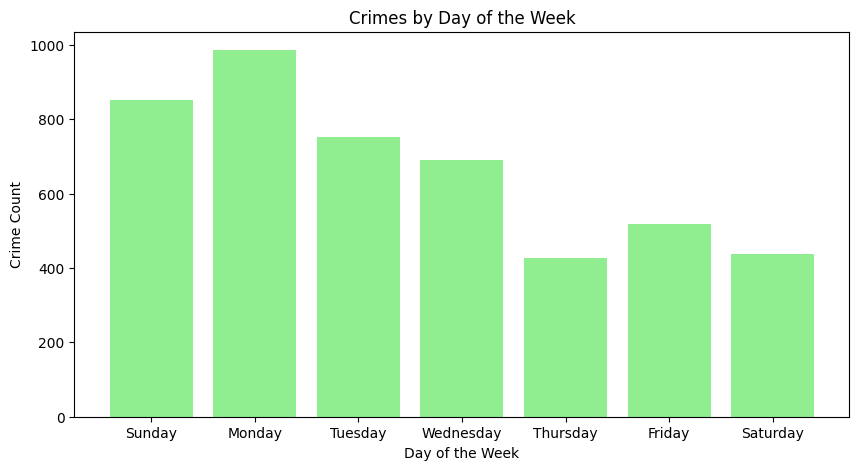

In [266]:
from pyspark.sql.functions import dayofweek

# Extract day of the week
df = df.withColumn("Day_of_Week", dayofweek("Cleaned_Date"))

# Group by day of the week and count incidents
crimes_by_day = df.groupBy("Day_of_Week").count().orderBy("Day_of_Week")

# Convert to Pandas for visualization
crimes_by_day_pd = crimes_by_day.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(crimes_by_day_pd["Day_of_Week"], crimes_by_day_pd["count"], color='lightgreen')
plt.title("Crimes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crime Count")
plt.xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


####  Analyzing Frequency of Crime Types

+--------------------+-----+
|    Type_of_Incident|count|
+--------------------+-----+
|                 BMV| 1315|
|BURGLARY OF HABIT...|  622|
|CRIM MISCHIEF >OR...|  616|
|ACCIDENT INV DAMA...|  548|
|BURGLARY OF BUILD...|  495|
|UNAUTHORIZED USE ...|  381|
|FOUND PROPERTY (N...|  336|
|ROBBERY OF INDIVI...|  312|
|ROBBERY OF BUSINE...|  304|
|ABANDONED PROPERT...|  285|
+--------------------+-----+



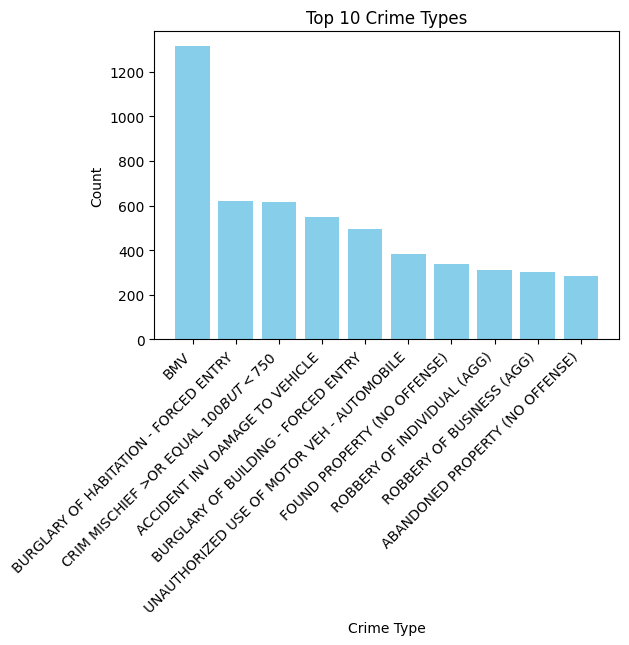

In [267]:
# Analyze top crime types
top_crime_types = df.groupBy("Type_of_Incident").count().orderBy("count", ascending=False).limit(10)

# Show the result
top_crime_types.show()

# Convert to Pandas for visualization
top_crime_types_pd = top_crime_types.toPandas()

# Bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(top_crime_types_pd["Type_of_Incident"], top_crime_types_pd["count"], color='skyblue')
plt.title("Top 10 Crime Types")
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()


#### Analyze Crime Trends Over Time

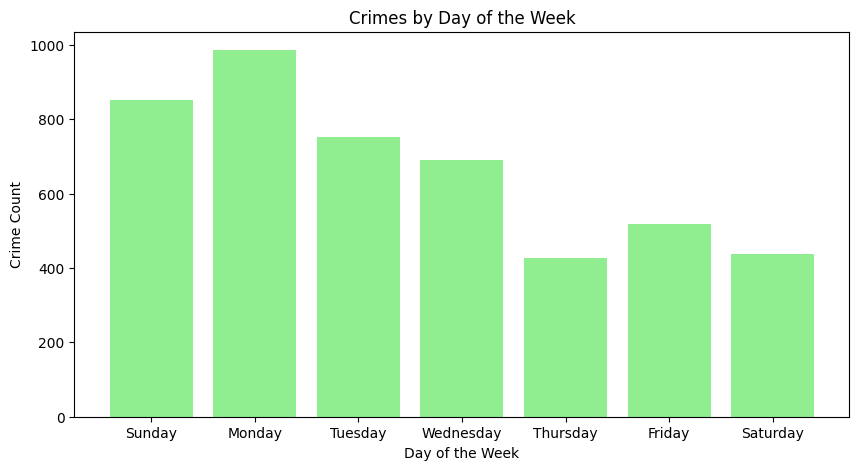

In [268]:
from pyspark.sql.functions import dayofweek

# Extract day of the week
df = df.withColumn("Day_of_Week", dayofweek("Cleaned_Date"))

# Group by day of the week and count incidents
crimes_by_day = df.groupBy("Day_of_Week").count().orderBy("Day_of_Week")

# Convert to Pandas for visualization
crimes_by_day_pd = crimes_by_day.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(crimes_by_day_pd["Day_of_Week"], crimes_by_day_pd["count"], color='lightgreen')
plt.title("Crimes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crime Count")
plt.xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


#### Number of Crime Incidents by Year and Location Type

<ipython-input-269-75084729d7fb>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date1 of Occurrence'] = pd.to_datetime(df['Date1 of Occurrence'], errors='coerce')


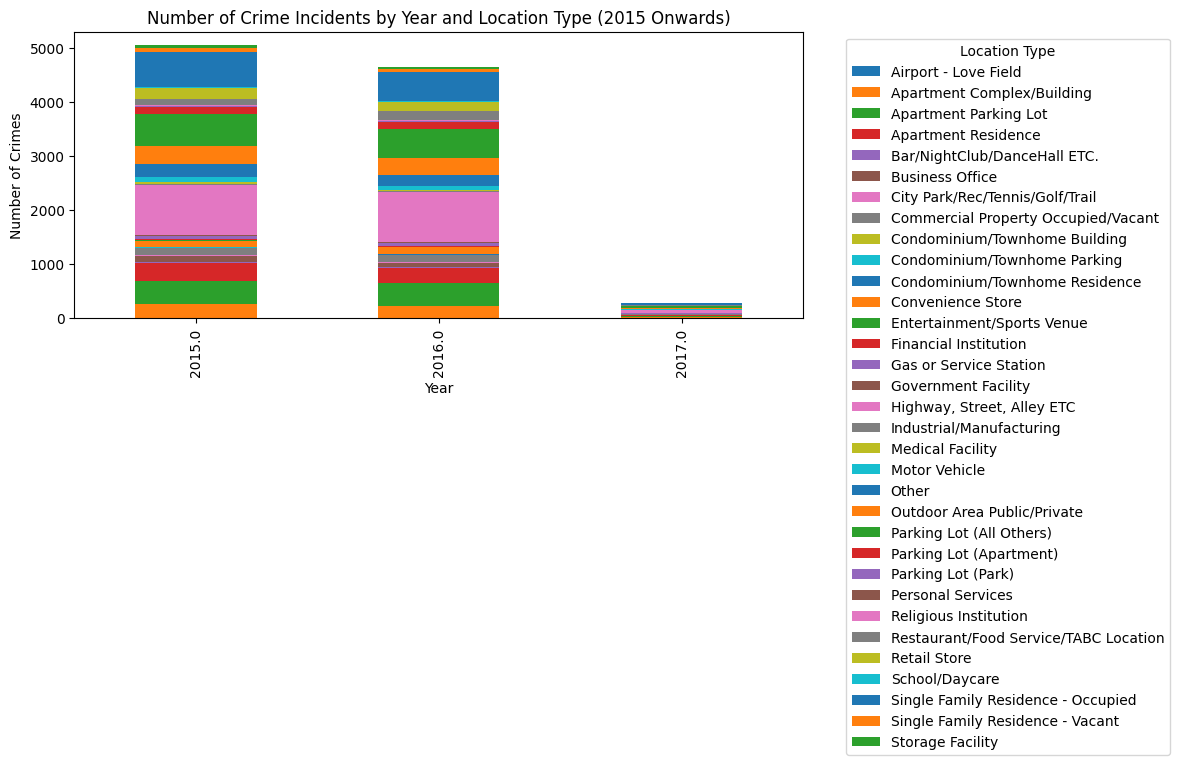

In [269]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Police_Incidents.csv')

# Clean column names
df.columns = [col.strip() for col in df.columns]

# Extract Year if not present
if 'Year' not in df.columns:
    df['Date1 of Occurrence'] = pd.to_datetime(df['Date1 of Occurrence'], errors='coerce')
    df['Year'] = df['Date1 of Occurrence'].dt.year

# Check if 'Type of Location' exists
if 'Type of Location' not in df.columns:
    raise KeyError("The 'Type of Location' column is missing. Please verify the dataset.")

# Filter data from the year 2015 onwards
df_filtered = df[df['Year'] >= 2015]

# Group data by 'Year' and 'Type of Location'
df_grouped = df_filtered.groupby(['Year', 'Type of Location']).size().reset_index(name='Number_of_crimes')

# Pivot the data for visualization
pivot = df_grouped.pivot(index='Year', columns='Type of Location', values='Number_of_crimes')

# Plot a stacked bar chart
pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add title, labels, and legend
plt.title('Number of Crime Incidents by Year and Location Type (2015 Onwards)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.legend(title='Location Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()


# Feature Engineering

In [241]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

# Extract temporal features
df = df.withColumn("Year", year("Cleaned_Date")) \
       .withColumn("Month", month("Cleaned_Date")) \
       .withColumn("Day", dayofmonth("Cleaned_Date")) \
       .withColumn("Day_of_Week", dayofweek("Cleaned_Date")) \
       .withColumn("Hour", hour("Cleaned_Date"))

# Verify extracted features
df.select("Cleaned_Date", "Year", "Month", "Day", "Day_of_Week", "Hour").show(5, truncate=False)


+------------+----+-----+---+-----------+----+
|Cleaned_Date|Year|Month|Day|Day_of_Week|Hour|
+------------+----+-----+---+-----------+----+
|2016-11-16  |2016|11   |16 |4          |0   |
|2016-11-20  |2016|11   |20 |1          |0   |
|2016-11-18  |2016|11   |18 |6          |0   |
|2016-11-18  |2016|11   |18 |6          |0   |
|2016-11-18  |2016|11   |18 |6          |0   |
+------------+----+-----+---+-----------+----+
only showing top 5 rows



In [242]:
from pyspark.ml.feature import StringIndexer

# Index categorical features
indexer = StringIndexer(inputCol="Type_of_Incident", outputCol="Incident_Index", handleInvalid="keep")
df = indexer.fit(df).transform(df)

# Verify the indexed column
df.select("Type_of_Incident", "Incident_Index").show(5, truncate=False)


+-------------------------------------------------------+--------------+
|Type_of_Incident                                       |Incident_Index|
+-------------------------------------------------------+--------------+
|BURGLARY OF HABITATION - FORCED ENTRY                  |1.0           |
|ACCIDENT INV DAMAGE TO VEHICLE                         |3.0           |
|FOUND PROPERTY (NO OFFENSE)                            |6.0           |
|ROBBERY OF BUSINESS (AGG)                              |8.0           |
|THEFT OF PROP > OR EQUAL $2,500 BUT <$30K- NOT SHOPLIFT|32.0          |
+-------------------------------------------------------+--------------+
only showing top 5 rows



In [243]:
from pyspark.sql.functions import when, col

# Create Binary_Incident_Index based on Incident_Index
df = df.withColumn(
    "Binary_Incident_Index",
    when(col("Incident_Index") == 1, 1).otherwise(0)
)

# Verify the binary labels
df.groupBy("Binary_Incident_Index").count().show()


+---------------------+-----+
|Binary_Incident_Index|count|
+---------------------+-----+
|                    1|  622|
|                    0| 9117|
+---------------------+-----+



In [244]:
# Oversample minority class and undersample majority class
majority = df.filter(col("Binary_Incident_Index") == 1).sample(withReplacement=False, fraction=0.5, seed=42)
minority = df.filter(col("Binary_Incident_Index") == 0).sample(withReplacement=True, fraction=2.0, seed=42)

# Combine the balanced dataset
balanced_df = majority.union(minority)

# Verify class distribution
balanced_df.groupBy("Binary_Incident_Index").count().show()


+---------------------+-----+
|Binary_Incident_Index|count|
+---------------------+-----+
|                    1|  331|
|                    0|18189|
+---------------------+-----+



In [249]:
# Oversample minority and undersample majority
majority = df.filter(col("Binary_Incident_Index") == 1).sample(withReplacement=False, fraction=0.5, seed=42)
minority = df.filter(col("Binary_Incident_Index") == 0).sample(withReplacement=True, fraction=2.0, seed=42)

balanced_df = majority.union(minority)

# Verify class distribution
balanced_df.groupBy("Binary_Incident_Index").count().show()


+---------------------+-----+
|Binary_Incident_Index|count|
+---------------------+-----+
|                    1|  331|
|                    0|18189|
+---------------------+-----+



In [251]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, Imputer

# Step 1: Verify column names
print("Columns in the dataset:", balanced_df.columns)

# Step 2: Define numerical columns (use exact column names from the dataset)
numerical_cols = ["_X_Coordinate_", "_Y_Coordinate", "Complainant_Age"]

# Step 3: Check for missing values in numerical columns
for col_name in numerical_cols:
    print(f"Checking missing values for column: {col_name}")
    balanced_df.filter(col(col_name).isNull()).show()

# Step 4: Handle missing values using Imputer
imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols)
balanced_df = imputer.fit(balanced_df).transform(balanced_df)

# Step 5: Assemble numerical features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
balanced_df = assembler.transform(balanced_df)

# Verify the assembled features
balanced_df.select("numerical_features").show(5, truncate=False)

# Step 6: Scale numerical features using MinMaxScaler
scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_features")
scaler_model = scaler.fit(balanced_df)
balanced_df = scaler_model.transform(balanced_df)

# Verify scaled features
balanced_df.select("numerical_features", "scaled_features").show(5, truncate=False)


Columns in the dataset: ['Incident_Number_w/_Year', 'Year_of_Incident', 'Incident_Number_wo/_Year', 'Offense_Service_Number', 'Service_Number_ID', 'Watch', 'Call_(911)_Problem', 'Type_of_Incident', 'Penalty_Class', 'Type_of_Location', 'Type_of_Property', 'Street_Block', 'Street_Direction', 'Street_Name', 'Incident_Address', 'Apartment_Number', 'Zip_Code', 'City', 'State', '_X_Coordinate_', '_Y_Coordinate', 'Reporting_Area', 'Beat', 'Division', 'Sector', 'Council_District', 'Target_Area_Action_Grids', 'Community', 'Date1_of_Occurrence', 'Year1_of_Occurrence', 'Month1_of_Occurence', 'Day1_of_the_Week', 'Time1_of_Occurrence', 'Day1_of_the_Year', 'Date2_of_Occurrence', 'Year2_of_Occurrence', 'Month2_of_Occurence', 'Day2_of_the_Week', 'Time2_of_Occurrence', 'Day2_of_the_Year', 'Starting__Date/Time', 'Ending_Date/Time', 'Map_Date', 'Date_of_Report', 'Date_incident_created', 'Offense_Entered_Year', 'Offense_Entered_Month', 'Offense_Entered_Day_of_the_Week', 'Offense_Entered_Time', 'Offense_En

In [252]:
# Combine scaled features and categorical features
final_assembler = VectorAssembler(
    inputCols=["scaled_features", "Incident_Index"],
    outputCol="features"
)
balanced_df = final_assembler.transform(balanced_df)

# Select final dataset for modeling
final_df = balanced_df.select("features", "Binary_Incident_Index")
final_df = final_df.withColumnRenamed("Binary_Incident_Index", "label")

# Verify final dataset
final_df.show(5, truncate=False)


+---------------------------------------------------------------+-----+
|features                                                       |label|
+---------------------------------------------------------------+-----+
|[0.38605567118595274,0.8174690183839924,0.2564102564102564,1.0]|1    |
|[0.2606876041069032,0.4203379676672106,0.28205128205128205,1.0]|1    |
|[0.6764385387785602,0.5367568696115954,0.10256410256410256,1.0]|1    |
|[0.4371082110983182,0.7114389418571841,0.8076923076923077,1.0] |1    |
|[0.7547750627381581,0.5793749778138851,0.2692307692307692,1.0] |1    |
+---------------------------------------------------------------+-----+
only showing top 5 rows



# Modeling

In [257]:
# Split the balanced dataset into training and testing sets
train, test = balanced_df.randomSplit([0.7, 0.3], seed=42)

print(f"Training set count: {train.count()}, Test set count: {test.count()}")


Training set count: 13036, Test set count: 5484


## Logistic Regression

In [258]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train Logistic Regression
lr = LogisticRegression(featuresCol="numerical_features", labelCol="Binary_Incident_Index", maxIter=10)
lr_model = lr.fit(train)

# Make predictions
lr_predictions = lr_model.transform(test)

# Evaluate Logistic Regression
evaluator = MulticlassClassificationEvaluator(labelCol="Binary_Incident_Index", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.9832239241429613


## Random Forest Classifier

In [255]:
from pyspark.ml.classification import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(featuresCol="numerical_features", labelCol="Binary_Incident_Index", numTrees=50, maxDepth=10)
rf_model = rf.fit(train)

# Make predictions
rf_predictions = rf_model.transform(test)

# Evaluate Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.9857573267597919


## Gradient-Boosted Trees

In [259]:
from pyspark.ml.classification import GBTClassifier

# Train Gradient-Boosted Trees
gbt = GBTClassifier(featuresCol="numerical_features", labelCol="Binary_Incident_Index", maxIter=50, maxDepth=5)
gbt_model = gbt.fit(train)

# Make predictions
gbt_predictions = gbt_model.transform(test)

# Evaluate Gradient-Boosted Trees
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")


Gradient-Boosted Trees Accuracy: 0.9832239241429613


# Evaluation Metrics

In [260]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Binary_Incident_Index", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Binary_Incident_Index", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Binary_Incident_Index", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Binary_Incident_Index", metricName="f1")

# Logistic Regression Metrics
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)

# Random Forest Metrics
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)

# Gradient-Boosted Trees Metrics
gbt_accuracy = accuracy_evaluator.evaluate(gbt_predictions)
gbt_precision = precision_evaluator.evaluate(gbt_predictions)
gbt_recall = recall_evaluator.evaluate(gbt_predictions)
gbt_f1 = f1_evaluator.evaluate(gbt_predictions)


# Compare Models

In [261]:
import pandas as pd

# Create a dictionary of metrics for each model
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient-Boosted Trees"],
    "Accuracy": [lr_accuracy, rf_accuracy, gbt_accuracy],
    "Precision": [lr_precision, rf_precision, gbt_precision],
    "Recall": [lr_recall, rf_recall, gbt_recall],
    "F1-Score": [lr_f1, rf_f1, gbt_f1],
}

# Convert dictionary to pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)


                    Model  Accuracy  Precision    Recall  F1-Score
0     Logistic Regression  0.983224   0.966729  0.983224  0.974907
1           Random Forest  0.985757   0.971718  0.985757  0.978687
2  Gradient-Boosted Trees  0.983224   0.966729  0.983224  0.974907


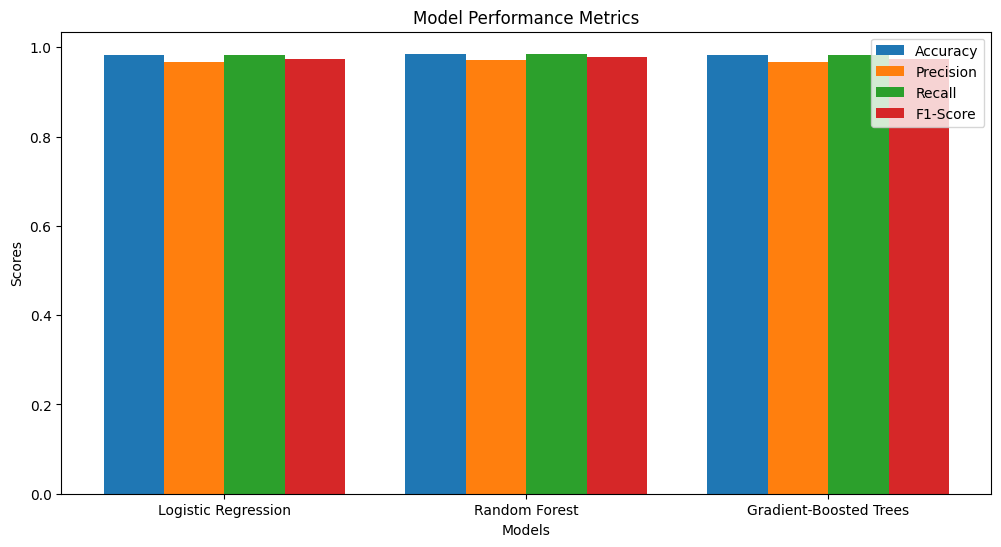

In [262]:
import matplotlib.pyplot as plt

# Prepare data for visualization
models = ['Logistic Regression', 'Random Forest', 'Gradient-Boosted Trees']
accuracy = [lr_accuracy, rf_accuracy, gbt_accuracy]
precision = [lr_precision, rf_precision, gbt_precision]
recall = [lr_recall, rf_recall, gbt_recall]
f1_score = [lr_f1, rf_f1, gbt_f1]

# Plot accuracy, precision, recall, and F1-Score
plt.figure(figsize=(12, 6))
x = range(len(models))

plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center')
plt.bar([p + 0.2 for p in x], precision, width=0.2, label='Precision', align='center')
plt.bar([p + 0.4 for p in x], recall, width=0.2, label='Recall', align='center')
plt.bar([p + 0.6 for p in x], f1_score, width=0.2, label='F1-Score', align='center')

# Add labels and legend
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Performance Metrics")
plt.xticks([p + 0.3 for p in x], models)
plt.legend()
plt.show()
